In [1]:
import sys, torch, os, json
print(f"pytorch version: {torch.__version__}")
import numpy as np
from tqdm import tqdm

module_rootdir = '.'
dataset_rootdir = '.'
label_rootdir = module_rootdir
sys.path.append(module_rootdir)

trained_weights_path = './model_weights/gnn/1715232829109/graph_based_detector.pt'
config_file_path = './configuration_radarscenes_gnn.yml'

from modules.set_configurations.set_config_gnn import config
from modules.data_utils.read_data import get_train_val_sequence_names
from modules.set_configurations.set_param_for_inference_gnn import set_parameters_for_inference
from modules.data_utils.read_data import get_sequence_data
from modules.data_utils.labels import compute_new_labels_to_id_dict
from modules.data_utils.labels import compute_old_to_new_label_id_map
from modules.performance.segmentation_accuracy import compute_gt_and_pred_semantic_class

save_model_performance_root_dir = './performance/semantic_segmentation'
os.makedirs(save_model_performance_root_dir, exist_ok=True)

pytorch version: 2.0.1


In [2]:
config_obj = config(config_file_path)
train_sequence_names, test_sequence_names = get_train_val_sequence_names(dataset_rootdir, config_obj.dataset_path)

print('train sequences')
print(train_sequence_names)
print('test sequences')
print(test_sequence_names)

train sequences
['sequence_1', 'sequence_2', 'sequence_3', 'sequence_4', 'sequence_7', 'sequence_8', 'sequence_9', 'sequence_10', 'sequence_11', 'sequence_12', 'sequence_13', 'sequence_15', 'sequence_16', 'sequence_17', 'sequence_18', 'sequence_20', 'sequence_21', 'sequence_22', 'sequence_23', 'sequence_25', 'sequence_26', 'sequence_27', 'sequence_28', 'sequence_29', 'sequence_30', 'sequence_32', 'sequence_33', 'sequence_34', 'sequence_35', 'sequence_36', 'sequence_37', 'sequence_38', 'sequence_39', 'sequence_40', 'sequence_41', 'sequence_43', 'sequence_44', 'sequence_45', 'sequence_46', 'sequence_47', 'sequence_49', 'sequence_50', 'sequence_51', 'sequence_52', 'sequence_54', 'sequence_55', 'sequence_56', 'sequence_57', 'sequence_59', 'sequence_60', 'sequence_61', 'sequence_62', 'sequence_64', 'sequence_65', 'sequence_66', 'sequence_67', 'sequence_69', 'sequence_70', 'sequence_71', 'sequence_72', 'sequence_74', 'sequence_75', 'sequence_76', 'sequence_77', 'sequence_78', 'sequence_80', 

In [3]:
eps = 1.5

param_obj = set_parameters_for_inference(module_rootdir, config_obj, trained_weights_path)
device = param_obj['device']
grid = param_obj['grid']
detector = param_obj['detector']
detector.set_param_for_proposal_extraction(eps) 

labels_to_id_dict = compute_new_labels_to_id_dict()
old_to_new_label_id_map = compute_old_to_new_label_id_map()

CLASS_NAMES = ['CAR', 'PEDESTRIAN', 'PEDESTRIAN_GROUP', 'TWO_WHEELER', 'LARGE_VEHICLE', 'NONE', 'FALSE']

GPU is available. Good to go!


In [4]:
all_sequence_names = test_sequence_names + train_sequence_names

for sequence_name in all_sequence_names:

    scene_metadata, radar_mount_data, radar_data_all_scenes, odometry_data_all_scenes \
            = get_sequence_data(dataset_rootdir, config_obj.dataset_path, sequence_name, config_obj.window_size)

    print(f"processing {sequence_name} with {len(scene_metadata)} number of frames")

    gt_count_matrix = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
    confusion_matrix = np.zeros((config_obj.num_classes, config_obj.num_classes), dtype=np.uint64)

    for idx in tqdm(range(len(scene_metadata))):

        gt_and_pred_node_class = compute_gt_and_pred_semantic_class(
                idx,
                scene_metadata,
                radar_mount_data,
                radar_data_all_scenes,
                odometry_data_all_scenes,
                labels_to_id_dict,
                old_to_new_label_id_map,
                grid, 
                config_obj, 
                device,
                detector)

        gt_semantic_class = gt_and_pred_node_class['gt_semantic_class'].astype(int)
        pred_semantic_class = gt_and_pred_node_class['pred_semantic_class'].astype(int)

        if gt_semantic_class.shape[0] != 0:
                for i in range(gt_semantic_class.shape[0]):
                        gt_count_matrix[gt_semantic_class[i]] += 1

        if gt_semantic_class.shape[0] != 0:
                for i in range(gt_semantic_class.shape[0]):
                        confusion_matrix[gt_semantic_class[i], pred_semantic_class[i]] += 1

    file_name = sequence_name + '.json'
    file_name = os.path.join(save_model_performance_root_dir, file_name)

    performance_data = {}
    performance_data['class_names'] = CLASS_NAMES
    performance_data['confusion_matrix'] = confusion_matrix.tolist()
    performance_data['gt_count_matrix'] = gt_count_matrix.tolist()

    with open(file_name, 'w') as json_file:
        json.dump(performance_data, json_file, indent=4)

processing sequence_5 with 4049 number of frames


100%|██████████| 4049/4049 [00:57<00:00, 70.96it/s]


processing sequence_6 with 3726 number of frames


100%|██████████| 3726/3726 [00:57<00:00, 64.53it/s]


processing sequence_14 with 2099 number of frames


100%|██████████| 2099/2099 [00:44<00:00, 47.69it/s]


processing sequence_19 with 4593 number of frames


100%|██████████| 4593/4593 [01:03<00:00, 72.13it/s] 


processing sequence_24 with 5760 number of frames


100%|██████████| 5760/5760 [01:29<00:00, 64.53it/s]


processing sequence_31 with 1510 number of frames


100%|██████████| 1510/1510 [00:13<00:00, 115.32it/s]


processing sequence_42 with 4412 number of frames


100%|██████████| 4412/4412 [01:17<00:00, 57.18it/s]


processing sequence_48 with 4997 number of frames


100%|██████████| 4997/4997 [01:29<00:00, 55.75it/s]


processing sequence_53 with 1501 number of frames


100%|██████████| 1501/1501 [00:24<00:00, 60.36it/s]


processing sequence_58 with 7434 number of frames


100%|██████████| 7434/7434 [01:39<00:00, 74.45it/s] 


processing sequence_63 with 4751 number of frames


100%|██████████| 4751/4751 [01:02<00:00, 75.59it/s] 


processing sequence_68 with 6102 number of frames


100%|██████████| 6102/6102 [01:25<00:00, 71.56it/s]


processing sequence_73 with 7021 number of frames


100%|██████████| 7021/7021 [01:53<00:00, 62.04it/s]


processing sequence_79 with 3680 number of frames


100%|██████████| 3680/3680 [01:05<00:00, 56.28it/s]


processing sequence_85 with 2541 number of frames


100%|██████████| 2541/2541 [01:04<00:00, 39.53it/s]


processing sequence_89 with 4351 number of frames


100%|██████████| 4351/4351 [01:16<00:00, 56.75it/s]


processing sequence_93 with 6014 number of frames


100%|██████████| 6014/6014 [02:06<00:00, 47.48it/s]


processing sequence_99 with 8837 number of frames


100%|██████████| 8837/8837 [03:20<00:00, 44.07it/s]


processing sequence_107 with 9285 number of frames


100%|██████████| 9285/9285 [04:21<00:00, 35.52it/s] 


processing sequence_111 with 1672 number of frames


100%|██████████| 1672/1672 [00:43<00:00, 38.65it/s]


processing sequence_122 with 894 number of frames


100%|██████████| 894/894 [00:08<00:00, 109.48it/s]


processing sequence_130 with 7374 number of frames


100%|██████████| 7374/7374 [01:43<00:00, 71.08it/s]  


processing sequence_135 with 5314 number of frames


100%|██████████| 5314/5314 [01:24<00:00, 62.63it/s]


processing sequence_138 with 7753 number of frames


100%|██████████| 7753/7753 [02:46<00:00, 46.64it/s]


processing sequence_147 with 6103 number of frames


100%|██████████| 6103/6103 [02:15<00:00, 44.91it/s]


processing sequence_148 with 6002 number of frames


100%|██████████| 6002/6002 [01:49<00:00, 54.91it/s]


processing sequence_153 with 4031 number of frames


100%|██████████| 4031/4031 [00:50<00:00, 80.29it/s]


processing sequence_155 with 5884 number of frames


100%|██████████| 5884/5884 [01:17<00:00, 75.95it/s]


processing sequence_1 with 4649 number of frames


100%|██████████| 4649/4649 [01:23<00:00, 55.86it/s] 


processing sequence_2 with 7647 number of frames


100%|██████████| 7647/7647 [03:19<00:00, 38.38it/s] 


processing sequence_3 with 1656 number of frames


100%|██████████| 1656/1656 [00:27<00:00, 60.68it/s]


processing sequence_4 with 1554 number of frames


100%|██████████| 1554/1554 [00:16<00:00, 94.86it/s] 


processing sequence_7 with 6205 number of frames


100%|██████████| 6205/6205 [01:40<00:00, 61.68it/s] 


processing sequence_8 with 3960 number of frames


100%|██████████| 3960/3960 [01:55<00:00, 34.25it/s]


processing sequence_9 with 4748 number of frames


100%|██████████| 4748/4748 [01:48<00:00, 43.77it/s]


processing sequence_10 with 11524 number of frames


100%|██████████| 11524/11524 [04:01<00:00, 47.63it/s]


processing sequence_11 with 1558 number of frames


100%|██████████| 1558/1558 [00:28<00:00, 53.98it/s]


processing sequence_12 with 2348 number of frames


100%|██████████| 2348/2348 [00:44<00:00, 52.74it/s]


processing sequence_13 with 2270 number of frames


100%|██████████| 2270/2270 [00:38<00:00, 58.44it/s] 


processing sequence_15 with 1061 number of frames


100%|██████████| 1061/1061 [00:16<00:00, 64.97it/s] 


processing sequence_16 with 1059 number of frames


100%|██████████| 1059/1059 [00:17<00:00, 59.65it/s] 


processing sequence_17 with 700 number of frames


100%|██████████| 700/700 [00:12<00:00, 54.66it/s]


processing sequence_18 with 971 number of frames


100%|██████████| 971/971 [00:16<00:00, 58.32it/s] 


processing sequence_20 with 7860 number of frames


100%|██████████| 7860/7860 [01:51<00:00, 70.36it/s] 


processing sequence_21 with 5801 number of frames


100%|██████████| 5801/5801 [01:22<00:00, 70.72it/s] 


processing sequence_22 with 8244 number of frames


100%|██████████| 8244/8244 [02:01<00:00, 68.09it/s]


processing sequence_23 with 6812 number of frames


100%|██████████| 6812/6812 [01:44<00:00, 64.91it/s]


processing sequence_25 with 7408 number of frames


100%|██████████| 7408/7408 [01:49<00:00, 67.64it/s]


processing sequence_26 with 6368 number of frames


100%|██████████| 6368/6368 [01:35<00:00, 66.61it/s]


processing sequence_27 with 8273 number of frames


100%|██████████| 8273/8273 [02:01<00:00, 68.17it/s]


processing sequence_28 with 11362 number of frames


100%|██████████| 11362/11362 [02:42<00:00, 69.95it/s]


processing sequence_29 with 7003 number of frames


100%|██████████| 7003/7003 [01:43<00:00, 67.51it/s]


processing sequence_30 with 4317 number of frames


100%|██████████| 4317/4317 [01:01<00:00, 70.59it/s]


processing sequence_32 with 6366 number of frames


100%|██████████| 6366/6366 [01:03<00:00, 100.40it/s]


processing sequence_33 with 7051 number of frames


100%|██████████| 7051/7051 [01:21<00:00, 86.91it/s] 


processing sequence_34 with 5048 number of frames


100%|██████████| 5048/5048 [00:34<00:00, 145.50it/s] 


processing sequence_35 with 725 number of frames


100%|██████████| 725/725 [00:11<00:00, 61.08it/s]


processing sequence_36 with 1810 number of frames


100%|██████████| 1810/1810 [00:32<00:00, 55.49it/s]


processing sequence_37 with 4980 number of frames


100%|██████████| 4980/4980 [01:12<00:00, 69.13it/s]


processing sequence_38 with 3015 number of frames


100%|██████████| 3015/3015 [00:50<00:00, 59.90it/s]


processing sequence_39 with 3872 number of frames


100%|██████████| 3872/3872 [00:56<00:00, 69.09it/s]


processing sequence_40 with 2992 number of frames


100%|██████████| 2992/2992 [00:50<00:00, 59.29it/s]


processing sequence_41 with 4617 number of frames


100%|██████████| 4617/4617 [01:23<00:00, 55.49it/s]


processing sequence_43 with 5932 number of frames


100%|██████████| 5932/5932 [01:27<00:00, 67.88it/s]


processing sequence_44 with 4515 number of frames


100%|██████████| 4515/4515 [01:11<00:00, 63.19it/s]


processing sequence_45 with 6989 number of frames


100%|██████████| 6989/6989 [02:03<00:00, 56.79it/s]


processing sequence_46 with 4785 number of frames


100%|██████████| 4785/4785 [01:24<00:00, 56.46it/s]


processing sequence_47 with 4810 number of frames


100%|██████████| 4810/4810 [01:14<00:00, 64.82it/s]


processing sequence_49 with 1586 number of frames


100%|██████████| 1586/1586 [00:20<00:00, 77.51it/s]


processing sequence_50 with 1042 number of frames


100%|██████████| 1042/1042 [00:15<00:00, 67.76it/s]


processing sequence_51 with 1879 number of frames


100%|██████████| 1879/1879 [00:31<00:00, 59.36it/s]


processing sequence_52 with 1563 number of frames


100%|██████████| 1563/1563 [00:26<00:00, 59.33it/s]


processing sequence_54 with 966 number of frames


100%|██████████| 966/966 [00:14<00:00, 65.86it/s]


processing sequence_55 with 1402 number of frames


100%|██████████| 1402/1402 [00:22<00:00, 61.38it/s]


processing sequence_56 with 4810 number of frames


100%|██████████| 4810/4810 [01:28<00:00, 54.26it/s]


processing sequence_57 with 4758 number of frames


100%|██████████| 4758/4758 [01:29<00:00, 52.96it/s]


processing sequence_59 with 2575 number of frames


100%|██████████| 2575/2575 [00:43<00:00, 59.62it/s] 


processing sequence_60 with 13841 number of frames


100%|██████████| 13841/13841 [04:15<00:00, 54.27it/s]


processing sequence_61 with 3948 number of frames


100%|██████████| 3948/3948 [01:11<00:00, 55.29it/s]


processing sequence_62 with 6556 number of frames


100%|██████████| 6556/6556 [01:28<00:00, 74.47it/s]


processing sequence_64 with 6754 number of frames


100%|██████████| 6754/6754 [02:03<00:00, 54.66it/s]


processing sequence_65 with 6694 number of frames


100%|██████████| 6694/6694 [01:53<00:00, 59.21it/s]


processing sequence_66 with 4974 number of frames


100%|██████████| 4974/4974 [01:13<00:00, 67.96it/s]


processing sequence_67 with 7797 number of frames


100%|██████████| 7797/7797 [02:19<00:00, 56.06it/s]


processing sequence_69 with 9500 number of frames


100%|██████████| 9500/9500 [03:02<00:00, 51.97it/s]


processing sequence_70 with 7713 number of frames


100%|██████████| 7713/7713 [01:50<00:00, 70.10it/s]


processing sequence_71 with 5289 number of frames


100%|██████████| 5289/5289 [01:11<00:00, 73.89it/s]


processing sequence_72 with 7047 number of frames


100%|██████████| 7047/7047 [02:04<00:00, 56.48it/s]


processing sequence_74 with 5607 number of frames


100%|██████████| 5607/5607 [01:31<00:00, 61.59it/s]


processing sequence_75 with 4489 number of frames


100%|██████████| 4489/4489 [01:30<00:00, 49.80it/s]


processing sequence_76 with 3712 number of frames


100%|██████████| 3712/3712 [01:40<00:00, 37.09it/s]


processing sequence_77 with 4296 number of frames


100%|██████████| 4296/4296 [01:25<00:00, 50.46it/s]


processing sequence_78 with 1362 number of frames


100%|██████████| 1362/1362 [00:23<00:00, 57.16it/s]


processing sequence_80 with 4875 number of frames


100%|██████████| 4875/4875 [01:59<00:00, 40.66it/s]


processing sequence_81 with 738 number of frames


100%|██████████| 738/738 [00:13<00:00, 53.94it/s]


processing sequence_82 with 4196 number of frames


100%|██████████| 4196/4196 [00:58<00:00, 71.61it/s] 


processing sequence_83 with 1576 number of frames


100%|██████████| 1576/1576 [00:45<00:00, 34.58it/s]


processing sequence_84 with 4200 number of frames


100%|██████████| 4200/4200 [01:49<00:00, 38.44it/s]


processing sequence_86 with 2433 number of frames


100%|██████████| 2433/2433 [01:06<00:00, 36.35it/s]


processing sequence_87 with 6064 number of frames


100%|██████████| 6064/6064 [02:22<00:00, 42.41it/s]


processing sequence_88 with 7007 number of frames


100%|██████████| 7007/7007 [02:55<00:00, 39.97it/s]


processing sequence_90 with 1489 number of frames


100%|██████████| 1489/1489 [00:31<00:00, 47.23it/s]


processing sequence_91 with 6297 number of frames


100%|██████████| 6297/6297 [02:10<00:00, 48.15it/s]


processing sequence_92 with 1979 number of frames


100%|██████████| 1979/1979 [00:35<00:00, 55.40it/s]


processing sequence_94 with 8751 number of frames


100%|██████████| 8751/8751 [02:56<00:00, 49.59it/s]


processing sequence_95 with 5630 number of frames


100%|██████████| 5630/5630 [01:57<00:00, 48.10it/s] 


processing sequence_96 with 1059 number of frames


100%|██████████| 1059/1059 [00:21<00:00, 49.87it/s]


processing sequence_97 with 8513 number of frames


100%|██████████| 8513/8513 [02:42<00:00, 52.42it/s]


processing sequence_98 with 6244 number of frames


100%|██████████| 6244/6244 [02:23<00:00, 43.47it/s]


processing sequence_100 with 7130 number of frames


100%|██████████| 7130/7130 [02:31<00:00, 47.16it/s]


processing sequence_101 with 7210 number of frames


100%|██████████| 7210/7210 [02:19<00:00, 51.64it/s]


processing sequence_102 with 6061 number of frames


100%|██████████| 6061/6061 [02:03<00:00, 49.03it/s]


processing sequence_103 with 2044 number of frames


100%|██████████| 2044/2044 [00:26<00:00, 77.92it/s]


processing sequence_104 with 6980 number of frames


100%|██████████| 6980/6980 [02:35<00:00, 44.85it/s]


processing sequence_105 with 6469 number of frames


100%|██████████| 6469/6469 [03:21<00:00, 32.12it/s]


processing sequence_106 with 6120 number of frames


100%|██████████| 6120/6120 [02:49<00:00, 36.21it/s]


processing sequence_108 with 8088 number of frames


100%|██████████| 8088/8088 [02:47<00:00, 48.27it/s]


processing sequence_109 with 9801 number of frames


100%|██████████| 9801/9801 [03:25<00:00, 47.75it/s]


processing sequence_110 with 9268 number of frames


100%|██████████| 9268/9268 [05:48<00:00, 26.56it/s]


processing sequence_112 with 10032 number of frames


100%|██████████| 10032/10032 [03:05<00:00, 54.14it/s]


processing sequence_113 with 10804 number of frames


100%|██████████| 10804/10804 [04:58<00:00, 36.16it/s]


processing sequence_114 with 4486 number of frames


100%|██████████| 4486/4486 [01:49<00:00, 41.10it/s] 


processing sequence_115 with 8416 number of frames


100%|██████████| 8416/8416 [02:45<00:00, 50.80it/s] 


processing sequence_116 with 1197 number of frames


100%|██████████| 1197/1197 [00:15<00:00, 77.03it/s] 


processing sequence_117 with 13147 number of frames


100%|██████████| 13147/13147 [04:39<00:00, 47.04it/s]


processing sequence_118 with 11132 number of frames


100%|██████████| 11132/11132 [03:28<00:00, 53.36it/s]


processing sequence_119 with 6797 number of frames


100%|██████████| 6797/6797 [02:13<00:00, 51.01it/s]


processing sequence_120 with 2897 number of frames


100%|██████████| 2897/2897 [01:05<00:00, 43.93it/s]


processing sequence_121 with 1215 number of frames


100%|██████████| 1215/1215 [00:27<00:00, 44.66it/s]


processing sequence_123 with 3104 number of frames


100%|██████████| 3104/3104 [00:56<00:00, 54.94it/s]


processing sequence_124 with 7045 number of frames


100%|██████████| 7045/7045 [01:45<00:00, 66.48it/s] 


processing sequence_125 with 4562 number of frames


100%|██████████| 4562/4562 [02:38<00:00, 28.87it/s]


processing sequence_126 with 7240 number of frames


100%|██████████| 7240/7240 [03:34<00:00, 33.71it/s]


processing sequence_127 with 6892 number of frames


100%|██████████| 6892/6892 [02:09<00:00, 53.29it/s]


processing sequence_128 with 8139 number of frames


100%|██████████| 8139/8139 [02:22<00:00, 57.30it/s]


processing sequence_129 with 6345 number of frames


100%|██████████| 6345/6345 [02:08<00:00, 49.42it/s]


processing sequence_131 with 2953 number of frames


100%|██████████| 2953/2953 [01:50<00:00, 26.79it/s]


processing sequence_132 with 5987 number of frames


100%|██████████| 5987/5987 [03:00<00:00, 33.23it/s]


processing sequence_133 with 7417 number of frames


100%|██████████| 7417/7417 [02:15<00:00, 54.71it/s] 


processing sequence_134 with 5136 number of frames


100%|██████████| 5136/5136 [01:51<00:00, 46.01it/s]


processing sequence_136 with 2474 number of frames


100%|██████████| 2474/2474 [00:20<00:00, 118.41it/s] 


processing sequence_137 with 7283 number of frames


100%|██████████| 7283/7283 [02:25<00:00, 49.94it/s]


processing sequence_139 with 4529 number of frames


100%|██████████| 4529/4529 [01:29<00:00, 50.39it/s]


processing sequence_140 with 8626 number of frames


100%|██████████| 8626/8626 [05:07<00:00, 28.06it/s]


processing sequence_141 with 4317 number of frames


100%|██████████| 4317/4317 [01:50<00:00, 38.94it/s]


processing sequence_142 with 9843 number of frames


100%|██████████| 9843/9843 [03:45<00:00, 43.58it/s] 


processing sequence_143 with 3579 number of frames


100%|██████████| 3579/3579 [01:27<00:00, 40.84it/s]


processing sequence_144 with 7368 number of frames


100%|██████████| 7368/7368 [02:51<00:00, 43.05it/s]


processing sequence_145 with 4820 number of frames


100%|██████████| 4820/4820 [01:57<00:00, 41.00it/s]


processing sequence_146 with 8110 number of frames


100%|██████████| 8110/8110 [03:54<00:00, 34.56it/s]


processing sequence_149 with 15332 number of frames


100%|██████████| 15332/15332 [03:11<00:00, 80.23it/s] 


processing sequence_150 with 2717 number of frames


100%|██████████| 2717/2717 [00:32<00:00, 82.91it/s]


processing sequence_151 with 3682 number of frames


100%|██████████| 3682/3682 [00:45<00:00, 81.12it/s]


processing sequence_152 with 5122 number of frames


100%|██████████| 5122/5122 [01:04<00:00, 79.57it/s]


processing sequence_154 with 5632 number of frames


100%|██████████| 5632/5632 [01:09<00:00, 81.59it/s]


processing sequence_156 with 5153 number of frames


100%|██████████| 5153/5153 [01:11<00:00, 71.68it/s]


processing sequence_157 with 6138 number of frames


100%|██████████| 6138/6138 [01:19<00:00, 77.24it/s] 


processing sequence_158 with 795 number of frames


100%|██████████| 795/795 [00:09<00:00, 83.29it/s]


## Test Dataset

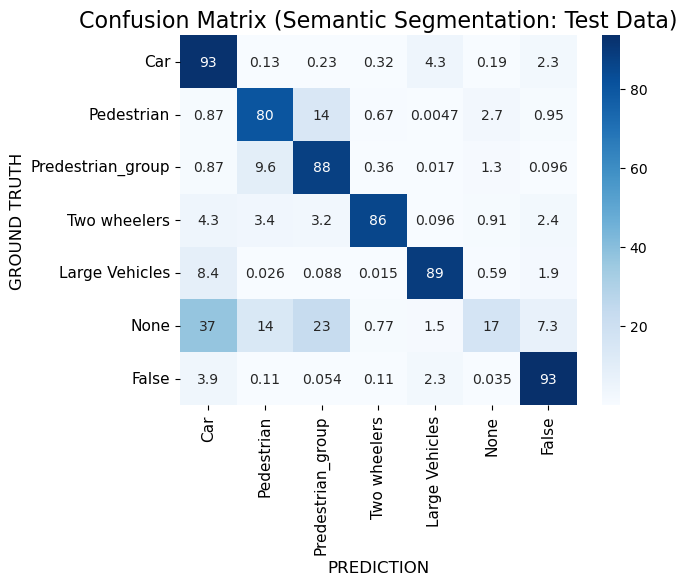

[[92.5   0.13  0.23  0.32  4.33  0.19  2.3 ]
 [ 0.87 80.3  14.46  0.67  0.    2.75  0.95]
 [ 0.87  9.62 87.71  0.36  0.02  1.32  0.1 ]
 [ 4.28  3.38  3.2  85.7   0.1   0.91  2.43]
 [ 8.45  0.03  0.09  0.02 88.97  0.59  1.86]
 [36.91 14.16 22.78  0.77  1.45 16.66  7.26]
 [ 3.91  0.11  0.05  0.11  2.33  0.04 93.47]]


In [5]:
gt_count_matrix_sum = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
confusion_matrix_sum = np.zeros((config_obj.num_classes, config_obj.num_classes), dtype=np.uint64)

for sequence_name in test_sequence_names:

    file_path = os.path.join(save_model_performance_root_dir, sequence_name + '.json')
    with open(file_path, 'r') as file:
        performance = json.load(file)

    confusion_matrix_sum += np.array(performance['confusion_matrix'], dtype=np.uint64)
    gt_count_matrix_sum += np.array(performance['gt_count_matrix'], dtype=np.uint64)


detection_rates = np.zeros(confusion_matrix_sum.shape, dtype=np.float32)
for i in range(gt_count_matrix_sum.shape[0]):
    num_gt = gt_count_matrix_sum[i]
    if num_gt > 0: detection_rates[i, :] = confusion_matrix_sum[i, :] / num_gt * 100
    else: detection_rates[i, :] = 0.0

import seaborn as sns
import matplotlib.pyplot as plt

CLASS_NAMES = ['Car', 'Pedestrian', 'Predestrian_group', 'Two wheelers', 'Large Vehicles', 'None', 'False']
hmap = sns.heatmap(data=detection_rates, annot=True, cmap='Blues')
hmap.set_title('Confusion Matrix (Semantic Segmentation: Test Data)', size=16)
hmap.set_xlabel('PREDICTION', size=12)
hmap.set_ylabel('GROUND TRUTH', size=12)
hmap.xaxis.set_ticklabels(CLASS_NAMES, rotation=90, size=11)
hmap.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, size=11)
fig = hmap.get_figure()
plt.show()

np.set_printoptions(suppress=True, precision=2)
print(detection_rates)


## Train Dataset

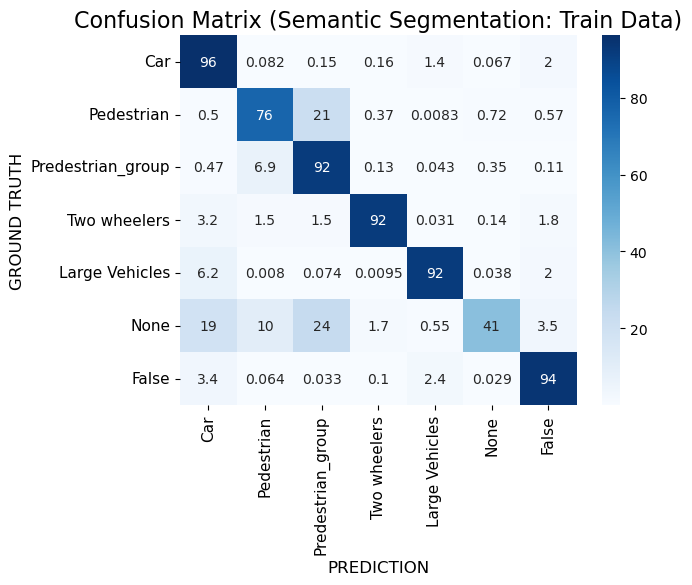

[[96.17  0.08  0.15  0.16  1.36  0.07  2.02]
 [ 0.5  76.34 21.49  0.37  0.01  0.72  0.57]
 [ 0.47  6.89 92.02  0.13  0.04  0.35  0.11]
 [ 3.16  1.46  1.5  91.92  0.03  0.14  1.79]
 [ 6.22  0.01  0.07  0.01 91.67  0.04  1.98]
 [18.67 10.32 24.4   1.72  0.55 40.8   3.54]
 [ 3.4   0.06  0.03  0.1   2.38  0.03 93.99]]


In [7]:
gt_count_matrix_sum = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
confusion_matrix_sum = np.zeros((config_obj.num_classes, config_obj.num_classes), dtype=np.uint64)

for sequence_name in train_sequence_names:

    file_path = os.path.join(save_model_performance_root_dir, sequence_name + '.json')
    with open(file_path, 'r') as file:
        performance = json.load(file)

    confusion_matrix_sum += np.array(performance['confusion_matrix'], dtype=np.uint64)
    gt_count_matrix_sum += np.array(performance['gt_count_matrix'], dtype=np.uint64)


detection_rates = np.zeros(confusion_matrix_sum.shape, dtype=np.float32)
for i in range(gt_count_matrix_sum.shape[0]):
    num_gt = gt_count_matrix_sum[i]
    if num_gt > 0: detection_rates[i, :] = confusion_matrix_sum[i, :] / num_gt * 100
    else: detection_rates[i, :] = 0.0

import seaborn as sns
import matplotlib.pyplot as plt

CLASS_NAMES = ['Car', 'Pedestrian', 'Predestrian_group', 'Two wheelers', 'Large Vehicles', 'None', 'False']
hmap = sns.heatmap(data=detection_rates, annot=True, cmap='Blues')
hmap.set_title('Confusion Matrix (Semantic Segmentation: Train Data)', size=16)
hmap.set_xlabel('PREDICTION', size=12)
hmap.set_ylabel('GROUND TRUTH', size=12)
hmap.xaxis.set_ticklabels(CLASS_NAMES, rotation=90, size=11)
hmap.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, size=11)
fig = hmap.get_figure()
plt.show()

np.set_printoptions(suppress=True, precision=2)
print(detection_rates)